In [ ]:
import os
import time
import json
import pickle
import ast
import re

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import joblib
import openai
import country_converter as coco
import pycountry_convert as pc

from itertools import chain
from copy import deepcopy

In [ ]:
# Set your API key
openai.api_key = ""

In [ ]:
# Load data
df_labelled = pd.read_csv("validation_data/labelled_data.csv")
df_predictions = pd.read_csv("final_dataset/pred_df.csv")
df_unlabelled = df_predictions[df_predictions['pred_label'] == 1].reset_index(drop=True)

Function to find the hazard type based on keywords

In [ ]:
def check_hazard_type_keyword(text):
    
    events = []

    if re.search(r"drought.*|dry spell.*", text, re.IGNORECASE):
        events.append('Drought')
    if re.search(r"flood.*|inundation.*|glacial lake outburst.*", text, re.IGNORECASE):
        events.append('Flood')
    if re.search(r"storm.*|superstorm.*|windstorm.*|snowstorm.*|blizzard.*|derecho.*|winterstorm.*|hail.*|extra tropical storm.*|thunderstorm.*|tornado.*|tropical cyclone.*|storm surge.*|hurricane.*|typhoon.*", text, re.IGNORECASE):
        events.append('Storm')
    if re.search(r"heat wave.*|heatwave.*|heat episode.*|((heat|hot) spell).*|heat stress.*", text, re.IGNORECASE):
        events.append('Heatwave')
    if re.search(r"cold wave.*|coldwave.*|severe winter conditions.*|cold spell.*", text, re.IGNORECASE):
        events.append('Coldwave')
    if re.search(r"land slide.*|landslide.*|rockfall.*|mudslide.*|mass movement.*", text, re.IGNORECASE):
        events.append('Mass movement')
    if re.search(r"fire.*|forestfire.*|wildfire.*|landfire.*|bushfire.*|forest fire.*|wild fire.*|land fire.*|bush fire.*", text, re.IGNORECASE):
        events.append('Wildfire')
        
    return events

Prompts to extract hazard information

In [6]:
def investigates_specific_events(text):
    prompt = f"""
    Context information is below.
    ---
    {text}
    ---
    Using only information from the text above, answer the query.
    Query: Does the text refer to a study that addresses one or more climate hazard events (i.e. it investigates the consequences of one or more events that happened in specific dates and locations)?
    Answer with 1 or 0. If yes, answer 1. If not, answer 0. Answer with either 1 or 0 and do not add extra text or notes.
    """
    return prompt

In [14]:
global example_range
example_range =     """{
      "startYear": 2002,
      "startMonth": 1,
      "startDay": 1,
      "endYear": 2015,
      "endMonth": 12,
      "endDay": 31,
      "hazardName": "",
      "country": "Brazil",
      "region": "",
      "state": "",
      "city": "",
      "otherLocation": ""
    }"""

In [15]:
def get_info_range(text, hazard):
    prompt = f"""
    Context information is below.
    ---
    {text}
    ---
    Using only information from the text above, please answer the query.
    Query: Considering that the text refers to an article that investigates a {hazard} across a specific time range, describe the study area and time range. 
    The study area should be described with country, region, state, city, lake, river, water basin or other location mentioned in the text. 
    The range for which the investigation was performed includes start Year (numeric), start Month (numeric), and start Day (numeric), end Year (numeric), end Month (numeric), and end Day (numeric)).
    Provide the answer in JSON format. 
    If information is missing, leave it empty. Do not add notes or extra text.
    Here is an example of how the structure of the JSON must be:
    {str(example_range)}
    """
    return prompt

In [17]:
def check_event_occurrence(text, hazard_type):
    prompt = f"""
    Context information is below.
    ---
    {text}
    ---
    Using only information from the text above and no previous knowledge, please answer the query.
    Query: Did a {hazard_type} event happened in the are investigated in the study?
    Answer with 1 or 0. If yes, answer 1. If not, answer 0. Answer with either 1 or 0 and do not add extra text or notes.
    """
    return prompt

In [18]:
global example_location
example_location =     """ {"hazardLocation": [
    {
      "country": "Brazil",
      "region": "",
      "state": "Ceará",
      "city": "Fortaleza, Bela Cruz",
      "locationAnnotation": ""
     },
    {
      "country": "United States",
      "region": "",
      "state": "California, Arizona",
      "city": "",
      "locationAnnotation": ""
     },
     {
      "country": "Colombia",
      "region": "",
      "state": "",
      "city": "",
      "locationAnnotation": ""
     }
     ]
     }
    """

def get_event_location(text, hazard_type):
    prompt = f"""
    Context information is below.
    ---
    {text}
    ---
    Using only information from the text above and no previous knowledge, please answer the query.
    Query: Where happened the {hazard_type} event investigated in the study?
    For each unique country where the event occurred, extract, if possible:
    "country": Country affected by the {hazard_type} event, mandatory field
    "region": Regions within the country affected by the {hazard_type} event
    "state": States within the country affected by the {hazard_type} event
    "state": Cities within the country affected by the {hazard_type} event
    "locationAnnotation": Provide the text excerpt from where you extracted the location information.
    If any of these information is missing from the text, leave the item empty. Do not add notes or extra text.
    Provide the answer in JSON format.
    Here is an example of how the structure of the JSON must be:
    {str(example_location)}
    """
    return prompt

In [ ]:
global example_date
example_date =     """{"hazardDate": [
    {
      "startYear": "2017",
      "startMonth": "8",
      "startDay": "30",
      "endYear": "2017",
      "endMonth": "9",
      "endDay": "13",
      "hazardName": "Hurricane Irma"
     },
     {
      "startYear": "2017",
      "startMonth": "9",
      "startDay": "16",
      "endYear": "2017",
      "endMonth": "9",
      "endDay": "30",
      "hazardName": "Hurricane Maria"
     }
     ]
     }
    """

In [ ]:
def get_event_date(text, hazard_type, hazard_location):
    prompt = f"""
    Context information is below.
    ---
    {text}
    ---
    Using only information from the text above and no previous knowledge, please answer the query.
    Query: When did the {hazard_type} event that affected {hazard_location} investigated in the study happened?
    The date in which the hazard happened should be described by: 
    "startYear": starting year, four numeric values "YYYY",
    "startMonth": starting month, one or two numeric values "MM",
    "startDay": starting day, one or two numeric values "DD",
    "endYear": ending year, four numeric values "YYYY",
    "endMonth": ending month, one or two numeric values "MM",
    "endDay": ending day, one or two numeric values "DD",
    "hazardName": If the hazard received a special name, such as "Hurricane Harvey" or "Storm Sandy", add it here, enclosed by double quotes
    If end year, end month, and end day are not mentioned in the text, repeat the values for start year, start month, and start day.
    Provide the answer in JSON format.
    If information is missing, leave it empty. Do not add notes or extra text.
    Here is an example of how the structure of the JSON must be:
    {str(example_date)}
    """
    return prompt

Functions to process LLM response

In [20]:
def extract_outer_json(text):
    start_index = text.find('{')
    end_index = text.rfind('}')

    if start_index == -1 or end_index == -1 or start_index >= end_index:
        return None  # Return None for empty JSON or invalid format

    extracted_json = text[start_index:end_index + 1]
    return extracted_json

In [ ]:
def run_llm(prompt, model_id="gpt-4o"):
    try:

        response = openai.ChatCompletion.create(
            model=model_id,  # or "gpt-4" if you have access
            messages=[
            #{"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
            ]
        )

        # Check if the expected keys are in the parsed data
        if "choices" in response and response["choices"] and "message" in response["choices"][0]:
            return response["choices"][0]["message"]["content"].strip()
        else:
            print("Error: Unexpected JSON structure")
            print("Parsed data:", response)
            return None

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [23]:
def add_key_value_pairs(data, new_pairs):
    """
    Adds new key-value pairs to each dictionary in a list of dictionaries.

    Parameters:
    data (list): A list of dictionaries.
    new_pairs (list or dict): A dictionary or list of dictionaries containing key-value pairs to be added.

    Returns:
    list: A list of dictionaries with the new key-value pairs added.
    """
    if isinstance(new_pairs, dict):
        # If new_pairs is a dictionary, add its key-value pairs to each dictionary in data
        for entry in data:
            for key, value in new_pairs.items():
                entry[key] = value
    elif isinstance(new_pairs, list):
        # If new_pairs is a list, add the corresponding dictionary's key-value pairs to the corresponding dictionary in data
        for entry, new_pair in zip(data, new_pairs):
            if isinstance(new_pair, dict):
                for key, value in new_pair.items():
                    entry[key] = value
    else:
        raise TypeError("new_pairs must be a dictionary or a list of dictionaries")
    
    return data

Run LLM and get information about the events from title and abstract

In [24]:
results = []
response = []

In [ ]:
# Identify location
def process_location(response, text, specific_event, reference_info, hazard, location, model_id):
    try:
        location_country = location["country"]
        print(f"Location: {location_country}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return

    if not location["country"]:
        print(f"Country not specified: {location}")
        return

    prompt = get_event_date(text, hazard, location_country)
    result = run_llm(prompt, model_id)
    result_json = extract_outer_json(result)

    try:
        answer_date = json.loads(result_json.replace("\n", ""))["hazardDate"]
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return

    if not answer_date:
        print(f"JSON is empty: {result_json}")
        return

    data = add_key_value_pairs([{"hazardType": hazard, "specificEvent": specific_event}], location)
    updated_data = deepcopy(add_key_value_pairs(data, answer_date))
    updated_data = deepcopy(add_key_value_pairs(updated_data, reference_info))

    response.append(deepcopy(updated_data))

In [ ]:
# Check if paper refers to a specific event in time in a given location
def process_specific_event(response, text, specific_event, reference_info, model_id):
    hazard_types = check_hazard_type_keyword(text)

    for hazard in hazard_types:
        print(f"Hazard: {hazard}")
        prompt = get_event_location(text, hazard)
        result = run_llm(prompt, model_id)
        result_json = extract_outer_json(result)

        try:
            answer_location = json.loads(result_json.replace("\n", ""))["hazardLocation"]
        except Exception as e:
            print(f"An unexpected error occurred: {e}")
            return

        if not answer_location:
            print(f"JSON is empty: {result_json}")
            return

        for location in answer_location:
            process_location(response, text, specific_event, reference_info, hazard, location, model_id)

def process_non_specific_event(response, text, specific_event, reference_info, model_id):
    hazard_types = check_hazard_type_keyword(text)

    for hazard in hazard_types:
        prompt = get_info_range(text, hazard)
        result = run_llm(prompt, model_id)
        result_json = extract_outer_json(result)

        try:
            answer_parts = json.loads(result_json.replace("\n", ""))
        except (json.JSONDecodeError, Exception) as e:
            print(f"An unexpected error occurred: {e}")
            print(f"Here is the result json: {result_json}")
            return

        if not answer_parts:
            print(f"JSON is empty: {result_json}")
            return

        print(f"Info: {answer_parts}")
        data_range = add_key_value_pairs([{"hazardType": hazard, "specificEvent": specific_event}], answer_parts)
        updated_data_range = add_key_value_pairs(data_range, reference_info)

        response.append(updated_data_range)

In [ ]:
def get_event_information(df_labelled, model_id=0, checkpoint_file="checkpoint.pkl"):
    # Load previous progress if available
    try:
        response = joblib.load(checkpoint_file)
        print(f"Loaded checkpoint from {checkpoint_file}")
    except (FileNotFoundError, EOFError):
        response = []

    processed_titles = {r['title'] for r in response}  # Titles already processed

    for id, df in df_labelled.groupby("title"):
        title = df["title"].iloc[0]

        if title in processed_titles:
            print(f"Skipping already processed title: {title}")
            continue

        abstract = df["abstract"].iloc[0]
        text = title + " " + abstract
        journal = df["journal"].values[0]
        doi = df["doi"].values[0]
        pmid = df["pmid"].values[0]
        source = df["source"].values[0]
        year = df["year"].values[0]

        reference_info = {
            "doi": doi,
            "pmid": pmid,
            "source": source,
            "journal": journal,
            "year": year,
            "title": title,
            "abstract": abstract
        }

        print(f"Processing title: {title}")

        prompt = investigates_specific_events(text)
        result = run_llm(prompt, model_id)
        specific_event = int(''.join(re.findall("[01]", result)))

        print(f"Specific event: {result}")

        if specific_event == 1:
            process_specific_event(response, text, specific_event, reference_info, model_id)
        else:
            print("Not a specific event")
            process_non_specific_event(response, text, specific_event, reference_info, model_id)

        # Save intermediate results
        joblib.dump(response, checkpoint_file)
        print(f"Saved checkpoint to {checkpoint_file}")

    response_unnested = list(chain(*response))
    response_df = pd.DataFrame(response_unnested)
    return response, response_df

In [ ]:
chunk_size = 50

# Create empty lists to store responses and response_dfs
all_responses = []
all_response_dfs = []

# Iterate over the DataFrame in chunks
for i in range(0, len(df_unlabelled), chunk_size):
    print("Chunk:")
    print(i)
    
    # Select the chunk
    chunk = df_unlabelled.iloc[i:i+chunk_size]
    
    # Apply the function to the chunk
    response, response_df = get_event_information(chunk, model_id="gpt-4o")
    
    # Append the results to the lists
    all_responses.append(response)
    all_response_dfs.append(response_df)
    
    print("Sleeping for 1 minute")
    time.sleep(10)

In [ ]:
response_df = pd.concat(all_response_dfs, ignore_index=True)

In [ ]:
response_df.to_csv("final_dataset/response_df_unlabelled_llm.csv", index=False)

Postprocessing

First, make sure that each country is considered as a separate entry

In [44]:
response_df_exploded = response_df.assign(country_split = response_df.country.str.split(',')).explode("country_split")
response_df_exploded = response_df_exploded.drop(columns="country").rename(columns={"country_split": "country"})

Trim whitespaces

In [45]:
response_df_exploded["country"] = [str(country).strip() for country in response_df_exploded["country"]]

Add ISO codes for countries

In [47]:
def add_country_codes(response_df):
    cc = coco.CountryConverter()
    response_df["country"] = response_df["country"].astype(str).str.strip('[]')
    response_df["country"] = response_df["country"].astype(str).str.replace('"', "")
    iso3_codes = cc.pandas_convert(series=response_df["country"], to='ISO3')
    response_df["countryCode"] = iso3_codes
    response_df["countryCode"] = [np.nan if code == "not found" else code for code in response_df["countryCode"]]
    response_df["countryCode"] = response_df["countryCode"].astype(str).str.strip('[]')
    response_df["countryCode"] = response_df["countryCode"].astype(str).str.replace("'", "")
    return(response_df)

In [ ]:
response_df_cc = add_country_codes(response_df_exploded)

If a ISO code was not found, it is likelly that it is not a country

In [ ]:
response_df_cc['countryCode'].replace('', np.nan, inplace=True)
response_df_cc.dropna(subset = ['countryCode'], inplace=True)

Check if the country is repeated for the same hazard and paper

In [50]:
# Assuming df is your DataFrame
group_columns = ['hazardType', 'startYear', 'doi', 'country']
join_columns = ['region', 'state', 'city']
first_columns = [col for col in response_df_cc.columns if col not in group_columns + join_columns]

# Define a custom aggregation function
def join_strings(series):
    return ', '.join(series.dropna().unique())

# Group by the required columns and aggregate
result_df = response_df_cc.groupby(group_columns).agg({**{col: join_strings for col in join_columns},
                                           **{col: 'first' for col in first_columns}}).reset_index()

In [ ]:
result_df.to_csv("final_dataset/response_df_unlabelled_processed.csv", index=False)

Validation

In [ ]:
df_labelled_event = pd.read_csv("data/labelled_data_hazard_description.csv")
df_labelled_event.rename(columns={'hazard': 'hazardType', 'paper_title': 'title', 'other_location': 'otherLocation', 'iso_3166_code': 'countryCode'}, inplace=True)
df_labelled_subset = df_labelled_event[["doi", "journal", "year", "title", "abstract", "hazardType", "country", "countryCode", "state", "city", "region", "otherLocation", "startYear", "startMonth", "startDay", "endYear", "endMonth", "endDay"]]

In [ ]:
def calculate_precision(df1, df2, precision_columns_list):
    # Replace "nan" with empty string in df2 for specified columns
    for column in precision_columns_list:
        df2[column] = ["" if str(value) == "nan" else value for value in df2[column]]

    # Initialize results dictionary
    results = {col: {"psum": 0, "count": 0} for col in precision_columns_list}

    # Group by 'doi' and calculate precision for each column
    for id, df in df1.groupby("doi"):
        tmp = df2[df2["doi"] == id].reset_index(drop=True)
        print("result:")
        print(tmp["city"])
        tmp2 = df.reset_index(drop=True)
        print("labelled:")
        print(tmp2["city"])
        
        if tmp.shape[0] == tmp2.shape[0]:
            for precision_column in precision_columns_list:
                precision_matches = (sorted(tmp[precision_column]) == sorted(tmp2[precision_column]))
                if precision_matches:
                    results[precision_column]["psum"] += 1
                results[precision_column]["count"] += 1

    # Calculate precision and create a DataFrame
    precision_values = []
    for precision_column in precision_columns_list:
        if results[precision_column]["count"] > 0:
            precision = results[precision_column]["psum"] / results[precision_column]["count"]
        else:
            precision = float('nan')  # Handle case where there is no data to calculate precision
        precision_values.append(precision)
    precision_df = pd.DataFrame([precision_values], columns=precision_columns_list)
    return precision_df

In [ ]:
precision_columns_list = ["hazardType", "country", "city", "state", "region", "countryCode", "startYear", "endYear"]
precision_df = calculate_precision(df_labelled_subset, result_df, precision_columns_list)

Plot world map

/var/folders/y0/v_28nz_97f19tbld9j3_xhxm0000gn/T/ipykernel_984/2187900937.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


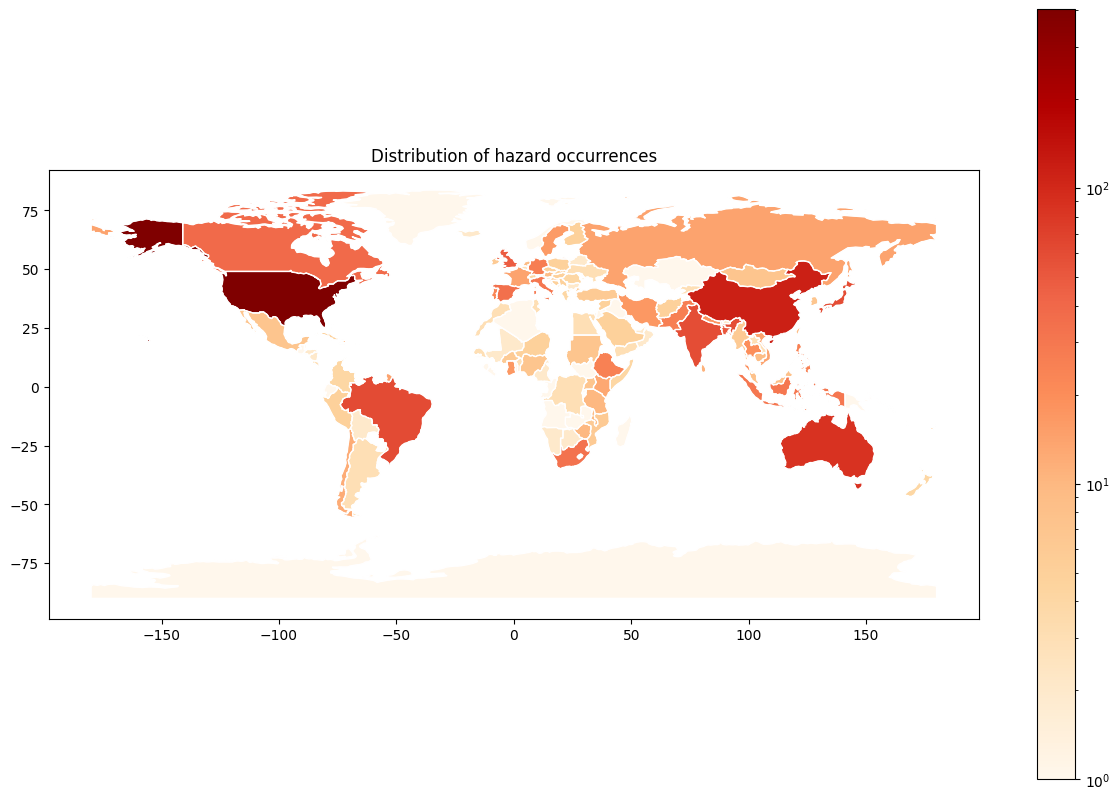

In [ ]:
df = result_df.copy()

# Aggregate data to count occurrences per country code
country_counts = df['countryCode'].value_counts().reset_index()
country_counts.columns = ['countryCode', 'count']

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the country counts with the world map using country codes (ISO_A3)
world = world.merge(country_counts, how='left', left_on='iso_a3', right_on='countryCode')

# Fill NaN values with 0 (indicating no occurrences)
world['count'] = world['count'].fillna(0)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world boundaries with white edges
world.boundary.plot(ax=ax, color='white', linewidth=0.5)

# Plot the filled countries with the count of occurrences, using a logarithmic color scale
world.plot(column='count', ax=ax, legend=True, cmap='OrRd',
           edgecolor='white', missing_kwds={'color': 'lightgrey'},
           norm=LogNorm(vmin=1, vmax=world['count'].max()),  # Log scale
           legend_kwds={'label': "",
                        'orientation': "vertical"})

# Set the title
plt.title('Distribution of hazard occurrences')
plt.show()